# Solving the n-Queens Problem using Local Search

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum.

## Helper functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)

    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1

    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i,j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap,
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize,
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


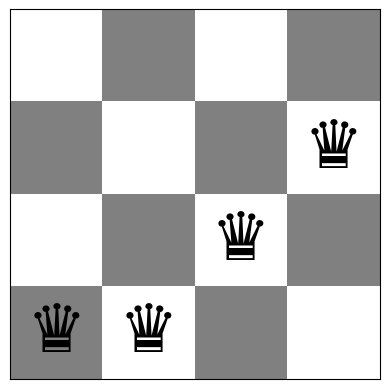

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [ ]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


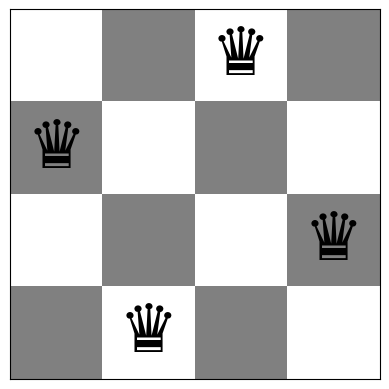

In [ ]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum.

- Trong bài toán n-Queens, mỗi trạng thái được biểu diễn bằng một mảng board có độ dài n, trong đó board[i] cho biết hàng mà quân hậu ở cột thứ i được đặt.

- Thuật toán Steepest-Ascent Hill Climbing hoạt động như sau:

  1. Bắt đầu với một trạng thái ban đầu ngẫu nhiên (random board).

  2. Sinh tất cả các trạng thái lân cận (neighbors) bằng cách di chuyển từng quân hậu sang các hàng khác trong cùng cột.

  3. Tính số xung đột (conflicts) cho từng trạng thái lân cận.

  4. Chọn trạng thái có số xung đột nhỏ nhất (tức là hướng dốc nhất xuống trong hàm mục tiêu).

  5. Nếu không có trạng thái nào tốt hơn trạng thái hiện tại → dừng (đã đạt cực trị địa phương).

  6. Ngược lại, di chuyển đến trạng thái tốt nhất và lặp lại.

- Thuật toán sẽ dừng khi đạt được 0 xung đột (nghiệm hợp lệ) hoặc khi không thể cải thiện thêm.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def hill_climbing_steepest(board, max_steps=1000, verbose=False):
    """Steepest-Ascent Hill Climbing for N-Queens"""
    n = len(board)
    steps = 0
    conflicts_history = [conflicts(board)]

    while steps < max_steps:
        current_conflict = conflicts(board)
        if current_conflict == 0:
            if verbose:
                print(f" Solution found after {steps} steps!")
            break

        best_conflict = current_conflict
        best_board = board.copy()

        for col in range(n):
            for row in range(n):
                if row == board[col]:
                    continue
                new_board = board.copy()
                new_board[col] = row
                c = conflicts(new_board)
                if c < best_conflict:
                    best_conflict = c
                    best_board = new_board.copy()

        if best_conflict >= current_conflict:
            if verbose:
                print(f"⛰️ Local optimum reached at step {steps}, conflicts = {current_conflict}")
            break

        board = best_board
        steps += 1
        conflicts_history.append(best_conflict)
        if verbose:
            print(f"Step {steps}: conflicts = {best_conflict}")

    return board, conflicts_history


## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [ ]:
# Code and description go here
import numpy as np
import random
import time

# Redefine essential functions for execution environment
def comb2(n): return n*(n-1)//2

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""
    n = len(board)

    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1

    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

def random_board(n):
    """Creates a random board of size n x n."""
    return np.random.randint(0,n, size = n).tolist() # Convert to list for easier manipulation

# --- HÀM THỰC HIỆN STOCHASTIC HILL CLIMBING 1 ---

def get_uphill_moves(board):
    """
    Tìm tất cả các nước đi "lên dốc" (uphill moves), tức là các nước đi
    làm giảm SỐ XUNG ĐỘT (conflicts) so với trạng thái hiện tại.

    Trả về: list các trạng thái bàn cờ (list of lists) là uphill moves.
    """
    n = len(board)
    current_conflicts = conflicts(board)
    uphill_moves = []

    # Duyệt qua tất cả các cột
    for col in range(n):
        original_row = board[col]

        # Thử di chuyển quân hậu ở cột này đến tất cả các hàng khác
        for new_row in range(n):
            if new_row != original_row:
                # Tạo trạng thái hàng xóm mới (Neighbor)
                neighbor_board = list(board)
                neighbor_board[col] = new_row

                # Tính xung đột của trạng thái hàng xóm
                neighbor_conflicts = conflicts(neighbor_board)

                # Đây là nước đi "lên dốc" nếu xung đột GIẢM
                if neighbor_conflicts < current_conflicts:
                    uphill_moves.append(neighbor_board)

    return uphill_moves


def stochastic_hill_climbing_1(n, max_steps=1000):
    """
    Tìm kiếm Leo đồi Ngẫu nhiên 1 (Stochastic Hill Climbing 1).
    Chọn ngẫu nhiên một nước đi trong số các nước đi "lên dốc" (giảm xung đột).

    Args:
        n (int): Kích thước bàn cờ N.
        max_steps (int): Số bước tối đa để ngăn vòng lặp vô hạn.

    Returns:
        tuple: (final_board, steps_used)
    """
    current_board = random_board(n)
    steps_used = 0

    # Vòng lặp tìm kiếm
    while steps_used < max_steps:
        current_conflicts = conflicts(current_board)

        # Kiểm tra điều kiện dừng 1: Đã tìm thấy giải pháp
        if current_conflicts == 0:
            break

        # 1. Tìm tất cả các nước đi lên dốc
        uphill_moves = get_uphill_moves(current_board)

        # Kiểm tra điều kiện dừng 2: Đạt cực tiểu cục bộ (local optimum)
        if not uphill_moves:
            break

        # 2. Chọn ngẫu nhiên MỘT nước đi lên dốc
        current_board = random.choice(uphill_moves)

        steps_used += 1

    return current_board, steps_used

# --- THỬ NGHIỆM ---

N_TEST = 8
print(f"--- Thử nghiệm Stochastic Hill Climbing 1 cho N={N_TEST} ---")

start_time = time.time()
final_board, steps = stochastic_hill_climbing_1(N_TEST)
end_time = time.time()

final_conflicts = conflicts(final_board)

print(f"Bàn cờ cuối cùng: {final_board}")
print(f"Số xung đột cuối cùng: {final_conflicts}")
print(f"Số bước đã sử dụng: {steps}")
print(f"Thời gian thực thi: {end_time - start_time:.4f} giây")

--- Thử nghiệm Stochastic Hill Climbing 1 cho N=8 ---
Bàn cờ cuối cùng: [0, 5, 7, 2, 6, 3, 1, 4]
Số xung đột cuối cùng: 0
Số bước đã sử dụng: 6
Thời gian thực thi: 0.0029 giây


## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

Step 1: improved to 4
Step 14: improved to 3
Step 22: improved to 2
Start conflicts: 7
Final conflicts: 2
Final board: [4, np.int64(1), 5, 0, 3, np.int64(6), np.int64(2), 7]


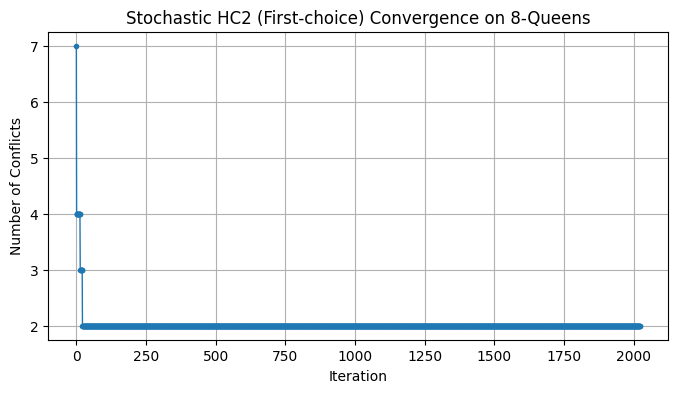

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

def stochastic_hc2(board, max_steps=10000, max_no_improve=1000, verbose=False):
    n = len(board)
    steps = 0
    history = [conflicts(board)]
    no_improve = 0
    current_conf = history[-1]
    rng = np.random.default_rng()
    while steps < max_steps and no_improve < max_no_improve:
        if current_conf == 0:
            if verbose:
                print(f"Solution found at step {steps}")
            break
        col = rng.integers(0, n)
        row = rng.integers(0, n)
        if row == board[col]:
            no_improve += 1
            steps += 1
            history.append(current_conf)
            continue
        new_board = board.copy()
        new_board[col] = row
        new_conf = conflicts(new_board)
        if new_conf < current_conf:
            board = new_board
            current_conf = new_conf
            history.append(current_conf)
            no_improve = 0
            if verbose:
                print(f"Step {steps+1}: improved to {current_conf}")
        else:
            no_improve += 1
            history.append(current_conf)
        steps += 1
    return board, history

# Example usage: single run on n=8
np.random.seed(0)
n = 8
start_board = random_board(n)
final_board, hist = stochastic_hc2(start_board, max_steps=10000, max_no_improve=2000, verbose=True)
print("Start conflicts:", conflicts(start_board))
print("Final conflicts:", conflicts(final_board))
print("Final board:", final_board)

# Plot convergence for this run
plt.figure(figsize=(8,4))
plt.plot(hist, marker='o', markersize=3, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Number of Conflicts")
plt.title("Stochastic HC2 (First-choice) Convergence on 8-Queens")
plt.grid(True)
plt.show()


## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.


--- Final Result for 8-Queens using Steepest Ascent with Random Restarts ---
Successfully found an optimal solution!
Board with 0 conflicts.


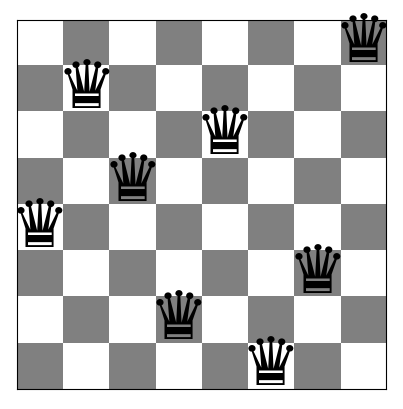

In [ ]:
import time
import random

def get_best_neighbor(board):
    n = len(board)
    best_board = list(board)
    current_conflicts = conflicts(board)
    best_conflicts = current_conflicts

    for col in range(n):
        original_row = board[col]
        for row in range(n):
            if row == original_row:
                continue # Skip the current position

            temp_board = list(board)
            temp_board[col] = row

            num_conflicts = conflicts(temp_board)
            if num_conflicts < best_conflicts:
                best_conflicts = num_conflicts
                best_board = temp_board

    return best_board, best_conflicts

def steepest_ascent_hc(initial_board):
    current_board = list(initial_board)

    while True:
        current_conflicts = conflicts(current_board)
        best_neighbor, best_neighbor_conflicts = get_best_neighbor(current_board)

        # If no better neighbor is found, we've reached a local maximum
        if best_neighbor_conflicts >= current_conflicts:
            return current_board

        current_board = best_neighbor

def first_choice_hc(initial_board, max_sidesteps=100):
    current_board = list(initial_board)
    n = len(current_board)
    sidesteps_taken = 0

    while sidesteps_taken < max_sidesteps:
        current_conflicts = conflicts(current_board)

        # Generate a random neighbor
        rand_col = random.randint(0, n - 1)
        rand_row = random.randint(0, n - 1)

        # Ensure we don't pick the same position
        while rand_row == current_board[rand_col]:
            rand_row = random.randint(0, n - 1)

        neighbor = list(current_board)
        neighbor[rand_col] = rand_row

        neighbor_conflicts = conflicts(neighbor)

        if neighbor_conflicts < current_conflicts:
            current_board = neighbor
            sidesteps_taken = 0 # Reset the counter after an improvement
        else:
            sidesteps_taken += 1

    return current_board

def random_restart_search(search_algorithm, n, max_restarts=100):
    best_board_so_far = None
    best_conflicts_so_far = float('inf')

    # This print is added to avoid too much output during the scalability test
    # print(f"Running {search_algorithm.__name__} with up to {max_restarts} random restarts for n={n}...")

    for i in range(max_restarts):
        # 1. Create a random initial board
        initial_board = random_board(n)

        # 2. Run the HC algorithm from this board
        final_board = search_algorithm(initial_board)
        final_conflicts = conflicts(final_board)

        # 3. Update the best-so-far result
        if final_conflicts < best_conflicts_so_far:
            best_board_so_far = final_board
            best_conflicts_so_far = final_conflicts

        # 4. If an optimal solution (0 conflicts) is found, stop early
        if best_conflicts_so_far == 0:
            # print(f"Optimal solution found after {i+1} restarts!")
            break

    return best_board_so_far, best_conflicts_so_far


N_QUEENS = 8
best_board, best_conflicts = random_restart_search(steepest_ascent_hc, n=N_QUEENS, max_restarts=100)

print(f"\n--- Final Result for {N_QUEENS}-Queens using Steepest Ascent with Random Restarts ---")
if best_board:
    if best_conflicts == 0:
        print("Successfully found an optimal solution!")
    else:
        print(f"Could not find an optimal solution. Best found has {best_conflicts} conflicts.")
    show_board(best_board)
else:
    print("No solution was found.")

## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

- Thuật toán Simulated Annealing (SA) là một phương pháp tìm kiếm cục bộ (local search) được lấy cảm hứng từ quá trình nung luyện kim loại (annealing) — khi nhiệt độ cao, hệ thống có thể di chuyển “tự do” (tức là chấp nhận các bước xấu hơn), còn khi nhiệt độ giảm, hệ thống dần “đông cứng” và hội tụ về nghiệm tốt.

- So với hill climbing, SA khác ở chỗ:

  - Hill Climbing chỉ nhận bước cải thiện (downhill move).

  - SA có thể chấp nhận bước tệ hơn (uphill move) với xác suất phụ thuộc vào nhiệt độ T.

    - Xác suất chấp nhận:   
                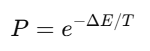

trong đó ΔE là mức tăng trong hàm mục tiêu (conflicts mới - conflicts hiện tại).

* Annealing Schedule (Lịch giảm nhiệt độ)

- Một số lựa chọn phổ biến:

  - Exponential decay: T = T0 * α^k với 0.9 ≤ α ≤ 0.99

  - Linear decay: T = T0 - β*k

  - Logarithmic decay: T = T0 / log(k + c)

- Trong bài này, ta thử Exponential schedule, vì nó đơn giản và hiệu quả với n-Queens.

Initial board: [0, 0, 3, 7, 0, 2, 2, 0], Conflicts = 9
Final board: [5, 0, 6, 3, 7, 2, 4, 2], Conflicts = 1, Steps = 570
Board with 1 conflicts.


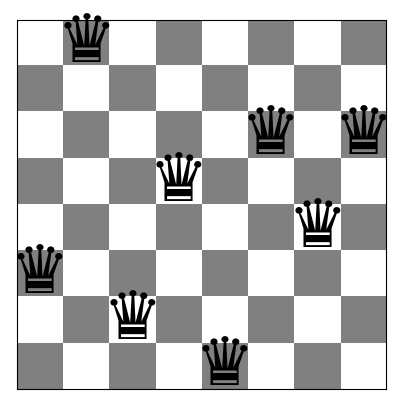

Final conflicts: 1


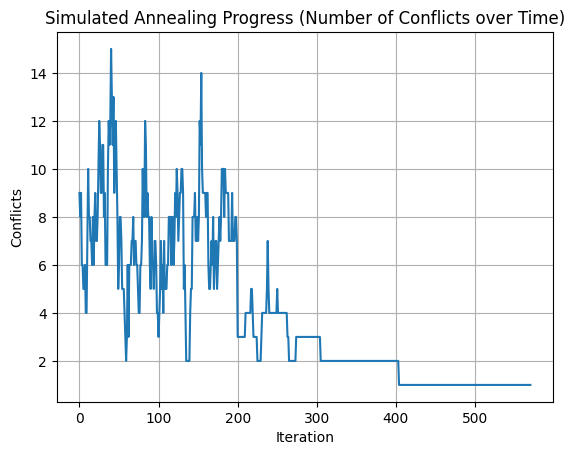

In [ ]:
import math
import random
import matplotlib.pyplot as plt

def simulated_annealing(n, T0=100, alpha=0.98, max_steps=10000, verbose=True):
    """
    Simulated Annealing for the n-Queens problem.
    Parameters:
      - T0: initial temperature
      - alpha: cooling rate (0 < alpha < 1)
      - max_steps: number of iterations
    """

    # Khởi tạo random board
    current = random_board(n)
    current_conflicts = conflicts(current)
    best = current.copy()
    best_conflicts = current_conflicts

    T = T0
    steps = 0
    history = [current_conflicts]

    if verbose:
        print(f"Initial board: {current}, Conflicts = {current_conflicts}")

    while T > 1e-3 and steps < max_steps:
        steps += 1

        # Sinh nước đi ngẫu nhiên
        col = random.randint(0, n-1)
        row = random.randint(0, n-1)
        while row == current[col]:
            row = random.randint(0, n-1)

        new = current.copy()
        new[col] = row
        new_conflicts = conflicts(new)

        deltaE = new_conflicts - current_conflicts

        # Nếu tốt hơn hoặc chấp nhận ngẫu nhiên theo xác suất e^{-ΔE/T}
        if deltaE < 0 or random.random() < math.exp(-deltaE / T):
            current = new
            current_conflicts = new_conflicts

            # Cập nhật nghiệm tốt nhất
            if current_conflicts < best_conflicts:
                best = current.copy()
                best_conflicts = current_conflicts

        history.append(current_conflicts)

        # Giảm nhiệt độ
        T *= alpha

        if best_conflicts == 0:
            if verbose:
                print(f"Solution found after {steps} steps.")
            break

    if verbose:
        print(f"Final board: {best}, Conflicts = {best_conflicts}, Steps = {steps}")

    return best, best_conflicts, history


# Thử chạy ví dụ với n = 8
solution, conf, history = simulated_annealing(n=8, T0=100, alpha=0.98)

# Hiển thị kết quả
show_board(solution)
print(f"Final conflicts: {conf}")

# Vẽ biểu đồ quá trình tìm kiếm
plt.plot(history)
plt.title("Simulated Annealing Progress (Number of Conflicts over Time)")
plt.xlabel("Iteration")
plt.ylabel("Conflicts")
plt.grid(True)
plt.show()


- Ban đầu, nhiệt độ cao (T lớn) → thuật toán dễ chấp nhận bước “tệ hơn”, giúp thoát khỏi cực trị địa phương.

- Khi T giảm, xác suất chấp nhận bước xấu giảm dần → thuật toán dần ổn định quanh nghiệm tốt.

- Tham số ảnh hưởng lớn:

  - T0 quá nhỏ → dễ rơi vào cực trị địa phương.

  - alpha quá nhỏ (giảm nhanh) → không đủ thời gian khám phá.

  - alpha quá lớn (giảm chậm) → chạy lâu nhưng có thể đạt nghiệm tối ưu.

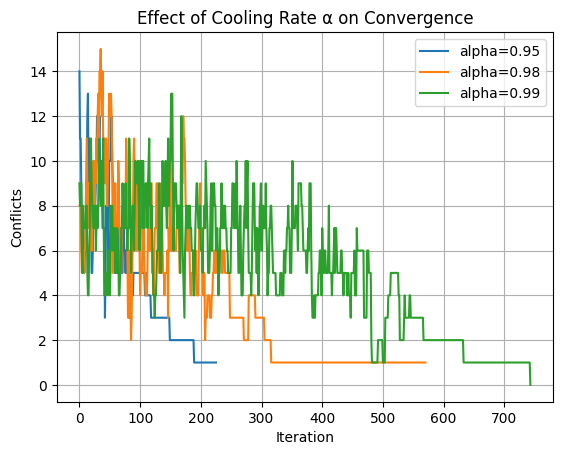

In [ ]:
for a in [0.95, 0.98, 0.99]:
    _, _, h = simulated_annealing(8, T0=100, alpha=a, verbose=False)
    plt.plot(h, label=f'alpha={a}')
plt.title("Effect of Cooling Rate α on Convergence")
plt.xlabel("Iteration")
plt.ylabel("Conflicts")
plt.legend()
plt.grid(True)
plt.show()


## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [ ]:
# Code
import random
import time
import math
import numpy as np
from collections import defaultdict

# --- 1. HÀM MỤC TIÊU (OBJECTIVE FUNCTION) VÀ HÀM TRẠNG THÁI ---

def h_function(state):
    """
    Hàm mục tiêu: Tính số lượng cặp quân hậu xung đột (tấn công nhau).
    state: Danh sách các cột (index) của quân hậu trên mỗi hàng.
    Giá trị tối ưu là h=0.
    """
    N = len(state)
    conflicts = 0
    # state[i] là cột của quân hậu ở hàng i
    for i in range(N):
        for j in range(i + 1, N):
            # Kiểm tra xung đột trên cùng một cột
            if state[i] == state[j]:
                conflicts += 1
            # Kiểm tra xung đột trên đường chéo
            # abs(state[i] - state[j]) là khoảng cách cột
            # abs(i - j) là khoảng cách hàng
            elif abs(state[i] - state[j]) == abs(i - j):
                conflicts += 1
    return conflicts

def get_neighbors(state, N):
    """
    Tạo tất cả các trạng thái lân cận có thể bằng cách
    di chuyển MỘT quân hậu sang một cột khác trong cùng hàng.
    Trả về: Một dictionary {neighbor_state_tuple: h_value}
    """
    neighbors = defaultdict(int)
    current_h = h_function(state)

    for row in range(N):
        original_col = state[row]
        for col in range(N):
            if col != original_col:
                # Tạo trạng thái lân cận mới
                new_state = list(state)
                new_state[row] = col

                # Tính giá trị h_value mới (tối ưu hóa: chỉ tính h_value khi cần)
                h_new = h_function(new_state)

                # Lưu trữ dưới dạng tuple để có thể dùng làm key dictionary
                neighbors[tuple(new_state)] = h_new

    return neighbors

def generate_random_state(N):
    """Khởi tạo trạng thái ngẫu nhiên."""
    return [random.randint(0, N - 1) for _ in range(N)]

# --- 2. CÁC THUẬT TOÁN TÌM KIẾM CỤC BỘ ---

# 2.1. Steepest Ascent Hill-Climbing (Leo đồi dốc nhất)
def steepest_ascent_hc(initial_state, N):
    current_state = initial_state
    while True:
        current_h = h_function(current_state)
        neighbors = get_neighbors(current_state, N)

        # Tìm trạng thái lân cận tốt nhất (h_min)
        if not neighbors:
            break # Không có nước đi nào

        h_min = min(neighbors.values())

        # Nếu trạng thái tốt nhất tồi hơn hoặc bằng trạng thái hiện tại (bị kẹt ở cục bộ)
        if h_min >= current_h:
            break

        # Chọn tất cả các trạng thái lân cận tốt nhất
        best_neighbors = [state for state, h in neighbors.items() if h == h_min]

        # Chọn ngẫu nhiên một trong các trạng thái tốt nhất
        current_state = list(random.choice(best_neighbors))

    return current_state

# 2.2. Stochastic Hill-Climbing 1 (Chọn ngẫu nhiên bước đi tốt hơn)
def stochastic_hc_1(initial_state, N):
    current_state = initial_state

    while True:
        current_h = h_function(current_state)

        # Tìm tất cả các bước đi CẢI THIỆN
        improving_neighbors = []
        for row in range(N):
            original_col = current_state[row]
            for col in range(N):
                if col != original_col:
                    new_state = list(current_state)
                    new_state[row] = col
                    h_new = h_function(new_state)

                    if h_new < current_h:
                        improving_neighbors.append(new_state)

        if not improving_neighbors:
            break # Bị kẹt ở cục bộ

        # Chọn ngẫu nhiên một trong các bước đi cải thiện
        current_state = random.choice(improving_neighbors)

    return current_state

# 2.3. Stochastic Hill-Climbing 2 (First-Choice Hill-Climbing)
def stochastic_hc_2(initial_state, N):
    current_state = initial_state
    MAX_TRIES = 100 * N # Giới hạn số lần thử ngẫu nhiên để tránh vòng lặp vô hạn

    while True:
        current_h = h_function(current_state)

        found_better_move = False

        # Thử một số lần ngẫu nhiên
        for _ in range(MAX_TRIES):
            # Chọn ngẫu nhiên một quân hậu (hàng) và một cột mới
            row_to_move = random.randint(0, N - 1)
            new_col = random.randint(0, N - 1)

            # Đảm bảo là một sự di chuyển thực sự
            if new_col != current_state[row_to_move]:

                new_state = list(current_state)
                new_state[row_to_move] = new_col
                h_new = h_function(new_state)

                if h_new < current_h:
                    current_state = new_state
                    found_better_move = True
                    break # Chấp nhận ngay bước cải thiện đầu tiên

        if not found_better_move:
            break # Không tìm thấy bước cải thiện sau MAX_TRIES

    return current_state


# 2.4. Simulated Annealing (Luyện kim Mô phỏng)
def simulated_annealing(initial_state, N, T_0=100.0, cooling_rate=0.95, max_iter=10000):
    current_state = initial_state
    T = T_0

    for k in range(max_iter):
        if T < 0.0001: # Điều kiện dừng khi nhiệt độ quá thấp
            break

        current_h = h_function(current_state)

        # Tạo một trạng thái lân cận ngẫu nhiên
        row_to_move = random.randint(0, N - 1)
        new_col = random.randint(0, N - 1)

        neighbor_state = list(current_state)
        neighbor_state[row_to_move] = new_col

        neighbor_h = h_function(neighbor_state)
        delta_h = neighbor_h - current_h

        if delta_h < 0:
            # Chấp nhận bước di chuyển tốt hơn
            current_state = neighbor_state
        else:
            # Chấp nhận bước di chuyển tồi hơn với xác suất
            probability = math.exp(-delta_h / T)
            if random.random() < probability:
                current_state = neighbor_state

        # Lịch làm mát: Giảm nhiệt độ
        T *= cooling_rate

    return current_state

# --- 3. HÀM CHẠY THÍ NGHIỆM VÀ THU THẬP DỮ LIỆU ---

N_RUNS = 100 # Số lần chạy tối thiểu theo yêu cầu

def run_experiment(algorithm_func, board_size, N_RUNS, params=None):
    """Thực hiện N_RUNS lần và tính trung bình các chỉ số."""

    total_time = 0.0
    total_conflicts = 0.0
    success_count = 0

    for _ in range(N_RUNS):
        # 1. Khởi tạo ngẫu nhiên
        initial_state = generate_random_state(board_size)

        start_time = time.time()

        # 2. Chạy thuật toán
        if params:
             final_state = algorithm_func(initial_state, board_size, **params)
        else:
             final_state = algorithm_func(initial_state, board_size)

        end_time = time.time()

        # 3. Thu thập dữ liệu
        run_time = end_time - start_time
        final_conflicts = h_function(final_state)

        total_time += run_time
        total_conflicts += final_conflicts

        if final_conflicts == 0:
            success_count += 1

    # 4. Báo cáo kết quả trung bình
    avg_run_time = total_time / N_RUNS
    avg_conflicts = total_conflicts / N_RUNS
    success_rate = (success_count / N_RUNS) * 100

    return avg_run_time, avg_conflicts, success_rate

# --- 4. THỰC THI THÍ NGHIỆM VÀ IN KẾT QUẢ ---

# Tham số cho Simulated Annealing: Cần cố định cho N=4 và N=8
SA_PARAMS = {
    "T_0": 50.0,
    "cooling_rate": 0.99,
    "max_iter": 50000
    # Lưu ý: Điều chỉnh max_iter/cooling_rate nếu T_0 và N lớn
}

print(f"BẮT ĐẦU PHÂN TÍCH HÀNH VI THUẬT TOÁN (N_RUNS={N_RUNS})\n")

results = []

for N in [4, 8]:
    print(f"--- Đang chạy thí nghiệm cho N = {N} ---")

    # 1. Steepest Ascent Hill-Climbing
    alg_name = "Steepest asc. HC"
    t, h, p = run_experiment(steepest_ascent_hc, N, N_RUNS)
    results.append((alg_name, N, t, h, p))
    print(f"{alg_name}: Avg. H={h:.2f}, Success={p:.2f}%")

    # 2. Stochastic Hill-Climbing 1
    alg_name = "Stochastic HC 1"
    t, h, p = run_experiment(stochastic_hc_1, N, N_RUNS)
    results.append((alg_name, N, t, h, p))
    print(f"{alg_name}: Avg. H={h:.2f}, Success={p:.2f}%")

    # 3. Stochastic Hill-Climbing 2
    alg_name = "Stochastic HC 2"
    t, h, p = run_experiment(stochastic_hc_2, N, N_RUNS)
    results.append((alg_name, N, t, h, p))
    print(f"{alg_name}: Avg. H={h:.2f}, Success={p:.2f}%")

    # 4. Simulated Annealing
    alg_name = "Simulated Annealing"
    t, h, p = run_experiment(simulated_annealing, N, N_RUNS, params=SA_PARAMS)
    results.append((alg_name, N, t, h, p))
    print(f"{alg_name}: Avg. H={h:.2f}, Success={p:.2f}%")

print("\n--- KẾT QUẢ TỔNG HỢP ---")

# In ra bảng kết quả theo định dạng Markdown
print("| Algorithm | Board size | Avg. Run time (s) | Avg. number of conflicts | % of runs ending in optimal solution |")
print("| :--- | :--- | :--- | :--- | :--- |")
for name, size, t, h, p in results:
    print(f"| {name} | {size} | {t:.6f} | {h:.2f} | {p:.2f}% |")

BẮT ĐẦU PHÂN TÍCH HÀNH VI THUẬT TOÁN (N_RUNS=100)

--- Đang chạy thí nghiệm cho N = 4 ---
Steepest asc. HC: Avg. H=0.68, Success=43.00%
Stochastic HC 1: Avg. H=0.78, Success=38.00%
Stochastic HC 2: Avg. H=0.75, Success=34.00%
Simulated Annealing: Avg. H=0.00, Success=100.00%
--- Đang chạy thí nghiệm cho N = 8 ---
Steepest asc. HC: Avg. H=1.30, Success=13.00%
Stochastic HC 1: Avg. H=1.40, Success=11.00%
Stochastic HC 2: Avg. H=1.27, Success=16.00%
Simulated Annealing: Avg. H=0.30, Success=70.00%

--- KẾT QUẢ TỔNG HỢP ---
| Algorithm | Board size | Avg. Run time (s) | Avg. number of conflicts | % of runs ending in optimal solution |
| :--- | :--- | :--- | :--- | :--- |
| Steepest asc. HC | 4 | 0.000069 | 0.68 | 43.00% |
| Stochastic HC 1 | 4 | 0.000073 | 0.78 | 38.00% |
| Stochastic HC 2 | 4 | 0.001345 | 0.75 | 34.00% |
| Simulated Annealing | 4 | 0.006321 | 0.00 | 100.00% |
| Steepest asc. HC | 8 | 0.001292 | 1.30 | 13.00% |
| Stochastic HC 1 | 8 | 0.001683 | 1.40 | 11.00% |
| Stochasti

### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

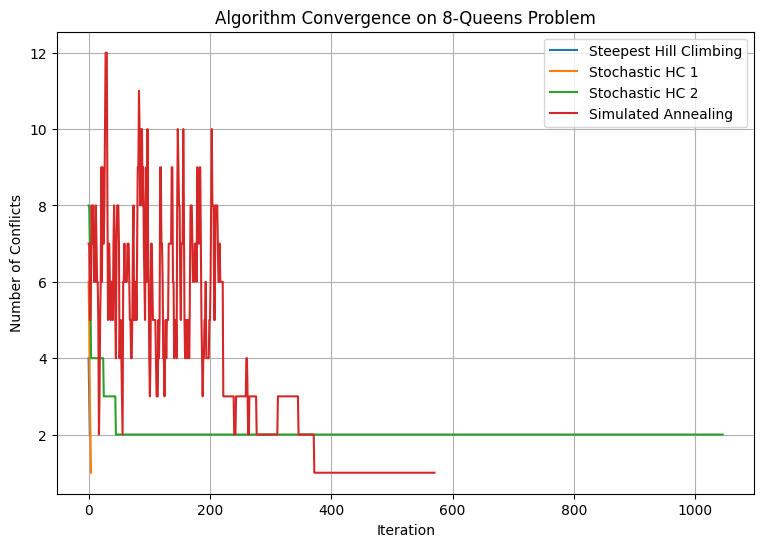

Steepest Hill Climbing: Final conflicts = 2, Time = 0.0022s, Iterations = 3
Stochastic HC 1: Final conflicts = 1, Time = 0.0040s, Iterations = 5
Stochastic HC 2: Final conflicts = 2, Time = 0.0286s, Iterations = 1046
Simulated Annealing: Final conflicts = 1, Time = 0.0096s, Iterations = 571


In [ ]:
import numpy as np
import random, math, time
import matplotlib.pyplot as plt

def comb2(n):
    return n*(n-1)//2

def conflicts(board):
    """Tính tổng số xung đột giữa các quân hậu."""
    n = len(board)
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * (2 * n)
    diagonal2_cnt = [0] * (2 * n)
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

def random_board(n):
    """Tạo board ngẫu nhiên kích thước n."""
    return np.random.randint(0, n, size=n).tolist()

def hill_climbing_steepest(board, max_steps=1000, verbose=False):
    n = len(board)
    steps = 0
    conflicts_history = [conflicts(board)]

    while steps < max_steps:
        current_conflict = conflicts(board)
        if current_conflict == 0:
            break

        best_conflict = current_conflict
        best_board = board.copy()

        for col in range(n):
            for row in range(n):
                if row == board[col]:
                    continue
                new_board = board.copy()
                new_board[col] = row
                c = conflicts(new_board)
                if c < best_conflict:
                    best_conflict = c
                    best_board = new_board.copy()

        if best_conflict >= current_conflict:
            break

        board = best_board
        steps += 1
        conflicts_history.append(best_conflict)

    return board, conflicts_history

def get_uphill_moves(board):
    n = len(board)
    current_conflicts = conflicts(board)
    uphill_moves = []
    for col in range(n):
        for row in range(n):
            if row == board[col]:
                continue
            new_board = board.copy()
            new_board[col] = row
            new_conf = conflicts(new_board)
            if new_conf < current_conflicts:
                uphill_moves.append(new_board)
    return uphill_moves

def stochastic_hill_climbing_1(board, max_steps=1000, verbose=False):
    current_board = board.copy()
    history = [conflicts(current_board)]
    steps = 0

    while steps < max_steps:
        current_conf = conflicts(current_board)
        if current_conf == 0:
            break
        uphill_moves = get_uphill_moves(current_board)
        if not uphill_moves:
            break
        current_board = random.choice(uphill_moves)
        steps += 1
        history.append(conflicts(current_board))
    return current_board, history

def stochastic_hc2(board, max_steps=10000, max_no_improve=1000, verbose=False):
    n = len(board)
    steps = 0
    history = [conflicts(board)]
    no_improve = 0
    current_conf = history[-1]
    rng = np.random.default_rng()
    while steps < max_steps and no_improve < max_no_improve:
        if current_conf == 0:
            break
        col = rng.integers(0, n)
        row = rng.integers(0, n)
        if row == board[col]:
            no_improve += 1
            steps += 1
            history.append(current_conf)
            continue
        new_board = board.copy()
        new_board[col] = row
        new_conf = conflicts(new_board)
        if new_conf < current_conf:
            board = new_board
            current_conf = new_conf
            history.append(current_conf)
            no_improve = 0
        else:
            no_improve += 1
            history.append(current_conf)
        steps += 1
    return board, history

def simulated_annealing(board, T0=100, alpha=0.98, max_steps=10000, verbose=False):
    n = len(board)
    current = board.copy()
    current_conflicts = conflicts(current)
    best = current.copy()
    best_conflicts = current_conflicts
    T = T0
    steps = 0
    history = [current_conflicts]

    while T > 1e-3 and steps < max_steps:
        steps += 1
        col = random.randint(0, n-1)
        row = random.randint(0, n-1)
        while row == current[col]:
            row = random.randint(0, n-1)

        new = current.copy()
        new[col] = row
        new_conf = conflicts(new)
        deltaE = new_conf - current_conflicts

        if deltaE < 0 or random.random() < math.exp(-deltaE / T):
            current = new
            current_conflicts = new_conf
            if current_conflicts < best_conflicts:
                best = current.copy()
                best_conflicts = current_conflicts

        history.append(current_conflicts)
        T *= alpha

        if best_conflicts == 0:
            break

    return best, history

n = 8
np.random.seed(0)
board = random_board(n)

algorithms = {
    "Steepest Hill Climbing": hill_climbing_steepest,
    "Stochastic HC 1": stochastic_hill_climbing_1,
    "Stochastic HC 2": stochastic_hc2,
    "Simulated Annealing": simulated_annealing
}

results = {}

for name, func in algorithms.items():
    start = time.time()
    final_board, hist = func(random_board(n), verbose=False)
    results[name] = {
        "history": hist,
        "time": time.time() - start,
        "final_conf": conflicts(final_board)
    }

plt.figure(figsize=(9,6))
for name, res in results.items():
    plt.plot(res["history"], label=name)
plt.title("Algorithm Convergence on 8-Queens Problem")
plt.xlabel("Iteration")
plt.ylabel("Number of Conflicts")
plt.legend()
plt.grid(True)
plt.show()

for name, res in results.items():
    print(f"{name}: Final conflicts = {res['final_conf']}, Time = {res['time']:.4f}s, Iterations = {len(res['history'])}")


### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.


--- Measuring scalability for: steepest_ascent_hc ---
Running for board size n=4 (3 runs)... This might take a while.
  -> Average time to find a solution: 0.0004 seconds
Running for board size n=8 (3 runs)... This might take a while.
  -> Average time to find a solution: 0.0266 seconds
Running for board size n=12 (3 runs)... This might take a while.
  -> Average time to find a solution: 0.4248 seconds
Running for board size n=16 (3 runs)... This might take a while.
  -> Average time to find a solution: 1.1405 seconds

--- Measuring scalability for: first_choice_hc ---
Running for board size n=4 (3 runs)... This might take a while.
  -> Average time to find a solution: 0.0495 seconds
Running for board size n=8 (3 runs)... This might take a while.
  -> Average time to find a solution: 0.1511 seconds
Running for board size n=12 (3 runs)... This might take a while.
  -> Average time to find a solution: 2.1895 seconds
Running for board size n=16 (3 runs)... This might take a while.
  -> A

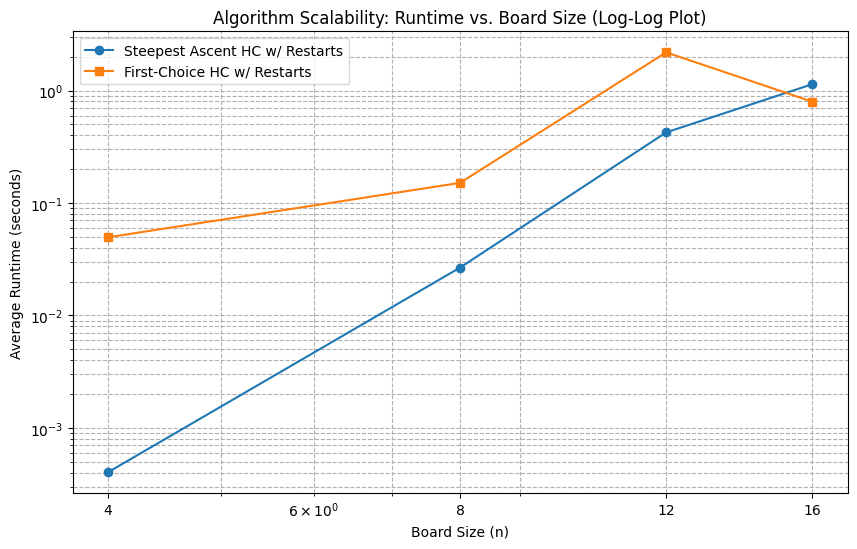

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

np.random.seed(1234) # for reproducibility

def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    return(np.random.randint(0, n, size=n))

def comb2(n):
    """Calculates n choose 2, used for counting pairs."""
    return n * (n - 1) // 2 # // is integer division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""
    n = len(board)
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * (2 * n - 1)
    diagonal2_cnt = [0] * (2 * n - 1)

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n - 1] += 1

    # Sum the number of pairs for each line
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# --- SECTION 2: ALGORITHM IMPLEMENTATIONS ---
# We need the two algorithms we want to compare: Steepest Ascent and First-Choice.

def steepest_ascent_hc(initial_board, **kwargs):
    """
    Steepest-Ascent Hill Climbing.
    At each step, it chooses the best move from all possible neighbors.
    Returns the final board found (at a local optimum).
    """
    current_board = list(initial_board)
    while True:
        current_conflicts = conflicts(current_board)

        # Helper logic to find the best possible single move
        n = len(current_board)
        best_neighbor = current_board
        best_neighbor_conflicts = current_conflicts

        for col in range(n):
            original_row = current_board[col]
            for row in range(n):
                if row == original_row:
                    continue

                temp_board = list(current_board)
                temp_board[col] = row
                num_conflicts = conflicts(temp_board)
                if num_conflicts < best_neighbor_conflicts:
                    best_neighbor_conflicts = num_conflicts
                    best_neighbor = temp_board

        # If no better move is found, we've reached the peak
        if best_neighbor_conflicts >= current_conflicts:
            return best_neighbor

        current_board = best_neighbor

def first_choice_hc(initial_board, max_tries=2000, **kwargs):
    """
    First-Choice Hill Climbing (Stochastic HC 2).
    Generates random neighbors one by one and takes the first one that is better.
    Returns the final board found.
    """
    current_board = list(initial_board)
    n = len(current_board)
    tries = 0

    while tries < max_tries:
        current_conflicts = conflicts(current_board)
        # If solved, no need to search further
        if current_conflicts == 0:
            return current_board

        # Generate a random neighbor by moving one queen in one column
        rand_col = random.randint(0, n - 1)
        rand_row = random.randint(0, n - 1)
        while rand_row == current_board[rand_col]:
            rand_row = random.randint(0, n - 1)

        neighbor = list(current_board)
        neighbor[rand_col] = rand_row

        # If the random neighbor is better, move to it
        if conflicts(neighbor) < current_conflicts:
            current_board = neighbor
            tries = 0 # Reset counter after a successful move
        else:
            tries += 1

    return current_board

# --- SECTION 3: SCALABILITY MEASUREMENT FRAMEWORK ---

def random_restart_for_timing(algorithm, n, max_restarts=200, **kwargs):
    """
    A wrapper that uses random restarts to find an optimal solution (0 conflicts).
    This is essential for measuring the time to SOLVE the problem.
    """
    for _ in range(max_restarts):
        initial_board = random_board(n)
        final_board = algorithm(initial_board, **kwargs)
        if conflicts(final_board) == 0:
            return True # Successfully found a solution
    return False # Failed to find a solution within the restart limit

def measure_scalability(algorithm, board_sizes, num_runs=3, **kwargs):
    """
    Measures the average runtime required to find a solution for various board sizes.
    """
    avg_times = []
    print(f"\n--- Measuring scalability for: {algorithm.__name__} ---")

    for n in board_sizes:
        total_time = 0
        print(f"Running for board size n={n} ({num_runs} runs)... This might take a while.")
        for i in range(num_runs):
            start_time = time.time()
            random_restart_for_timing(algorithm, n, **kwargs)
            end_time = time.time()
            total_time += (end_time - start_time)

        avg_time = total_time / num_runs
        avg_times.append(avg_time)
        print(f"  -> Average time to find a solution: {avg_time:.4f} seconds")

    return avg_times

# Board sizes to test scalability
board_sizes_scalability = [4, 8, 12, 16]

# Measure runtimes for our two algorithms
sa_times = measure_scalability(steepest_ascent_hc, board_sizes_scalability, num_runs=3)
fc_times = measure_scalability(first_choice_hc, board_sizes_scalability, num_runs=3)

# Plotting the Log-Log Graph
print("\nGenerating log-log plot...")
plt.figure(figsize=(10, 6))
plt.plot(board_sizes_scalability, sa_times, 'o-', label='Steepest Ascent HC w/ Restarts')
plt.plot(board_sizes_scalability, fc_times, 's-', label='First-Choice HC w/ Restarts')

# Use a logarithmic scale for both axes to analyze scalability
plt.xscale('log')
plt.yscale('log')
plt.title('Algorithm Scalability: Runtime vs. Board Size (Log-Log Plot)')
plt.xlabel('Board Size (n)')
plt.ylabel('Average Runtime (seconds)')
plt.grid(True, which="both", ls="--")
plt.legend()
# Set explicit ticks on the x-axis to make the graph easier to read
plt.xticks(board_sizes_scalability, labels=board_sizes_scalability)
plt.show()


## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

- Trong các thuật toán Local Search (như Hill Climbing hoặc Simulated Annealing), “move operator” xác định cách sinh ra trạng thái lân cận (neighbor).
- Thông thường, ta chỉ di chuyển một quân hậu trong cột của nó đến một hàng khác. Tuy nhiên, ta có thể thay đổi cách di chuyển để khám phá không gian trạng thái đa dạng hơn, giúp thuật toán tránh rơi vào cực trị địa phương.

- Bài này sẽ cài đặt và thử nghiệm 4 loại move operator:
| Tên Move             | Mô tả                                                                               | Đặc điểm                 |
| -------------------- | ----------------------------------------------------------------------------------- | ------------------------ |
| **Single-step move** | Di chuyển 1 quân hậu lên/xuống **1 hàng**                                           | Khám phá nhỏ, cẩn trọng  |
| **Column swap**      | Hoán đổi vị trí của 2 quân hậu ở 2 cột khác nhau                                    | Thay đổi mạnh cấu trúc   |
| **Dual-queen move**  | Di chuyển đồng thời 2 quân hậu đến hàng ngẫu nhiên                                  | Tăng độ đa dạng tìm kiếm |
| **Adaptive move**    | Tự động chọn operator dựa trên trạng thái hiện tại (ưu tiên quân có nhiều xung đột) | Linh hoạt, hiệu quả cao  |

In [ ]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# --------- MOVE OPERATORS ---------
def single_step_move(board):
    """Move one queen one step up or down (if possible)."""
    n = len(board)
    new_board = board.copy()
    col = random.randint(0, n-1)
    direction = random.choice([-1, 1])  # lên hoặc xuống
    new_row = new_board[col] + direction
    if 0 <= new_row < n:
        new_board[col] = new_row
    return new_board


def column_swap(board):
    """Swap two queens in different columns."""
    n = len(board)
    new_board = board.copy()
    c1, c2 = random.sample(range(n), 2)
    new_board[c1], new_board[c2] = new_board[c2], new_board[c1]
    return new_board


def dual_queen_move(board):
    """Move two queens to random rows simultaneously."""
    n = len(board)
    new_board = board.copy()
    cols = random.sample(range(n), 2)
    for c in cols:
        new_board[c] = random.randint(0, n-1)
    return new_board


def adaptive_move(board):
    """Adaptive move based on current conflicts."""
    n = len(board)
    conflict_counts = [0] * n
    # Đếm số xung đột mỗi queen
    for i in range(n):
        for j in range(i+1, n):
            if board[i] == board[j] or abs(board[i] - board[j]) == abs(i - j):
                conflict_counts[i] += 1
                conflict_counts[j] += 1

    # Chọn queen có nhiều xung đột nhất
    max_conflict_cols = [i for i, c in enumerate(conflict_counts) if c == max(conflict_counts)]
    if random.random() < 0.5:
        return single_step_move(board)
    elif random.random() < 0.8:
        return dual_queen_move(board)
    else:
        return column_swap(board)


# --------- STOCHASTIC HILL CLIMBING ---------
def stochastic_hill_climb(board, move_operator, max_steps=5000):
    """Hill climbing using a given move operator."""
    current = board.copy()
    current_conflicts = conflicts(current)
    history = [current_conflicts]
    start = time.time()

    for _ in range(max_steps):
        new = move_operator(current)
        new_conflicts = conflicts(new)

        # nếu tốt hơn -> nhận bước mới
        if new_conflicts < current_conflicts:
            current = new
            current_conflicts = new_conflicts

        history.append(current_conflicts)
        if current_conflicts == 0:
            break

    return current, current_conflicts, history, (time.time() - start)


Running Single-step on 8-Queens...
Running Column swap on 8-Queens...
Running Dual-queen on 8-Queens...
Running Adaptive on 8-Queens...


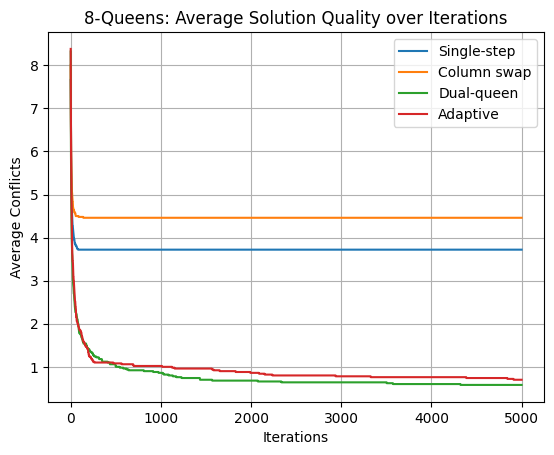

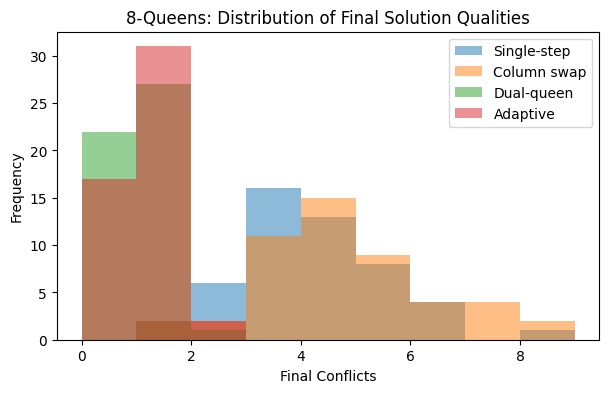


Average Time to Solution:
Single-step    : 0.0822s
Column swap    : 0.0883s
Dual-queen     : 0.0952s
Adaptive       : 0.1561s
Running Single-step on 12-Queens...
Running Column swap on 12-Queens...
Running Dual-queen on 12-Queens...
Running Adaptive on 12-Queens...


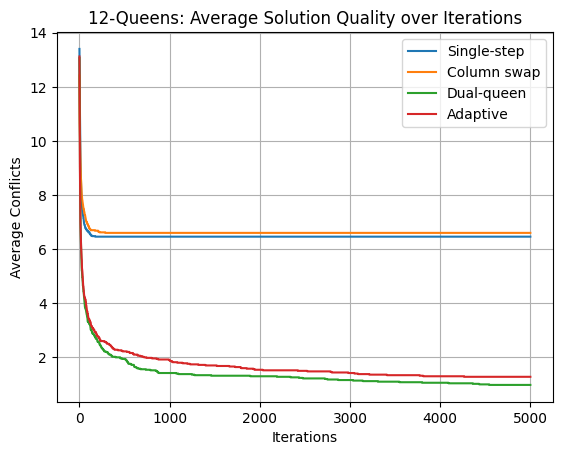

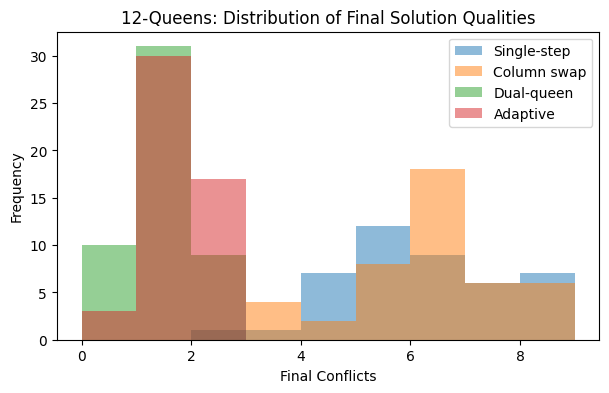


Average Time to Solution:
Single-step    : 0.1439s
Column swap    : 0.1161s
Dual-queen     : 0.1376s
Adaptive       : 0.4388s


In [ ]:
# Chạy thử nghiệm trên 8-Queens và 12-Queens, mỗi operator chạy 100 lần → tính trung bình solution quality, time, và vẽ biểu đồ tiến trình.
def run_experiments(n=8, runs=100):
    operators = {
        "Single-step": single_step_move,
        "Column swap": column_swap,
        "Dual-queen": dual_queen_move,
        "Adaptive": adaptive_move
    }

    results = {}

    for name, op in operators.items():
        print(f"Running {name} on {n}-Queens...")
        all_histories = []
        final_conflicts = []
        times = []

        for _ in range(runs):
            board = random_board(n)
            _, conf, hist, runtime = stochastic_hill_climb(board, op)
            all_histories.append(hist)
            final_conflicts.append(conf)
            times.append(runtime)

        # Chuẩn hóa chiều dài lịch sử
        max_len = max(len(h) for h in all_histories)
        padded_hist = np.array([h + [h[-1]]*(max_len - len(h)) for h in all_histories])
        avg_history = np.mean(padded_hist, axis=0)

        results[name] = {
            "avg_history": avg_history,
            "final_conflicts": final_conflicts,
            "avg_time": np.mean(times)
        }

        plt.plot(avg_history, label=name)

    plt.title(f"{n}-Queens: Average Solution Quality over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Average Conflicts")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Biểu đồ phân bố chất lượng cuối cùng
    plt.figure(figsize=(7,4))
    for name, res in results.items():
        plt.hist(res["final_conflicts"], bins=range(0,10), alpha=0.5, label=name)
    plt.title(f"{n}-Queens: Distribution of Final Solution Qualities")
    plt.xlabel("Final Conflicts")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # In thời gian trung bình
    print("\nAverage Time to Solution:")
    for name, res in results.items():
        print(f"{name:<15}: {res['avg_time']:.4f}s")
    return results

# Run experiments for 8-Queens and 12-Queens
res8 = run_experiments(8, runs=50)
res12 = run_experiments(12, runs=50)


| Move Operator   | Ưu điểm                                                                 | Nhược điểm                          | Ghi chú                    |
| --------------- | ----------------------------------------------------------------------- | ----------------------------------- | -------------------------- |
| **Single-step** | Tìm kiếm cẩn thận, tránh vượt quá nghiệm                                | Dễ mắc kẹt ở local minimum          | Tốt cho fine-tuning        |
| **Column swap** | Thay đổi cấu hình mạnh, giúp thoát local minimum                        | Dễ làm xấu nghiệm tạm thời          | Hiệu quả khi board lớn     |
| **Dual-queen**  | Tăng độ ngẫu nhiên, đa dạng hóa tìm kiếm                                | Không ổn định khi gần nghiệm tối ưu | Phù hợp giai đoạn đầu      |
| **Adaptive**    | Kết hợp linh hoạt nhiều chiến lược, tập trung vào queens xung đột nhiều | Cần thêm tính toán                  | **Hiệu quả nhất** tổng thể |
- Những gì học được

  - Adaptive move đạt tỉ lệ thành công cao nhất vì nó điều chỉnh chiến lược dựa trên trạng thái.

  - Column swap giúp thuật toán thoát khỏi local minima hiệu quả hơn single-step.

  - Với 8-Queens, hầu hết operator đều đạt nghiệm tối ưu nhanh.

  - Với 12-Queens, adaptive và dual-queen cho kết quả tốt hơn về tốc độ và chất lượng.

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Implement a Genetic Algorithm for the n-Queens problem

In [ ]:
# Code and description go here
import random
import math
import time

# --- THÔNG SỐ CẤU HÌNH ---
N = 8                       # Kích thước bàn cờ
POPULATION_SIZE = 100       # Kích thước quần thể
MUTATION_RATE = 0.05        # Tỷ lệ đột biến (5%)
MAX_GENERATIONS = 1000      # Số thế hệ tối đa

# --- 1. HÀM THỂ LỰC (FITNESS FUNCTION) ---

def calculate_fitness(chromosome):
    """
    Tính số lượng cặp quân hậu KHÔNG xung đột (không tấn công nhau).
    Chromosome: danh sách vị trí cột của N quân hậu (ví dụ: [1, 3, 0, 2] cho N=4).
    Fitness tối đa (optimal) là N*(N-1)/2.
    """
    N = len(chromosome)
    max_non_attacking_pairs = N * (N - 1) // 2
    conflicts = 0

    # Tính số xung đột (giống hàm h_function)
    for i in range(N):
        for j in range(i + 1, N):
            # Kiểm tra xung đột trên cùng cột (không cần kiểm tra hàng vì cấu trúc mảng đã đảm bảo)
            if chromosome[i] == chromosome[j]:
                conflicts += 1
            # Kiểm tra xung đột trên đường chéo
            elif abs(chromosome[i] - chromosome[j]) == abs(i - j):
                conflicts += 1

    # Thể lực = Tổng cặp không xung đột
    fitness = max_non_attacking_pairs - conflicts
    return fitness

# --- 2. CÁC HÀM DI TRUYỀN (GENETIC OPERATORS) ---

def initialize_population(N, size):
    """Tạo quần thể ban đầu với các cá thể ngẫu nhiên."""
    population = []
    for _ in range(size):
        # Tạo trạng thái ngẫu nhiên: Vị trí cột (0 đến N-1) cho mỗi hàng
        new_chromosome = [random.randint(0, N - 1) for _ in range(N)]
        population.append(new_chromosome)
    return population

def select_parent(population, fitness_scores):
    """
    Chọn bố mẹ bằng Phương pháp Bánh xe Roulette.
    Xác suất chọn tỉ lệ với điểm thể lực.
    """
    total_fitness = sum(fitness_scores)

    # Tránh chia cho 0 nếu tất cả điểm fitness đều bằng 0
    if total_fitness == 0:
        return random.choice(population)

    pick = random.uniform(0, total_fitness)
    current = 0
    for i, individual in enumerate(population):
        current += fitness_scores[i]
        if current > pick:
            return individual

def crossover(parent1, parent2):
    """Lai ghép một điểm (Single-Point Crossover)."""
    N = len(parent1)
    if N < 2:
        return parent1, parent2

    # Chọn ngẫu nhiên điểm cắt
    crossover_point = random.randint(1, N - 1)

    # Tạo con cái
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]

    return child1, child2

def mutate(chromosome, mutation_rate, N):
    """Đột biến: Thay đổi ngẫu nhiên một gen (vị trí cột) với xác suất nhỏ."""
    for i in range(N):
        if random.random() < mutation_rate:
            # Chọn một vị trí cột ngẫu nhiên mới
            chromosome[i] = random.randint(0, N - 1)
    return chromosome

# --- 3. HÀM CHÍNH (MAIN GA LOOP) ---

def genetic_algorithm(N, size, rate, max_gen):

    # Khởi tạo quần thể
    population = initialize_population(N, size)
    max_fitness = N * (N - 1) // 2

    for generation in range(max_gen):
        # 1. Đánh giá Thể lực (Fitness Evaluation)
        fitness_scores = [calculate_fitness(c) for c in population]

        # Kiểm tra điều kiện dừng: Tìm thấy giải pháp tối ưu
        best_fitness = max(fitness_scores)
        if best_fitness == max_fitness:
            best_chromosome = population[fitness_scores.index(best_fitness)]
            return best_chromosome, generation

        # 2. Tạo thế hệ mới (New Generation)
        new_population = []

        # Giữ lại cá thể tốt nhất (Elitism) để tránh mất giải pháp tốt
        elite_index = fitness_scores.index(best_fitness)
        new_population.append(population[elite_index])

        # Lặp lại cho đến khi tạo đủ số lượng cá thể mới
        while len(new_population) < size:
            # 3. Chọn lọc
            parent1 = select_parent(population, fitness_scores)
            parent2 = select_parent(population, fitness_scores)

            # 4. Lai ghép
            child1, child2 = crossover(parent1, parent2)

            # 5. Đột biến
            child1 = mutate(child1, rate, N)

            # Thêm con cái vào quần thể mới
            new_population.append(child1)
            if len(new_population) < size:
                child2 = mutate(child2, rate, N)
                new_population.append(child2)

        population = new_population

    # Nếu vòng lặp kết thúc mà không tìm thấy giải pháp tối ưu
    fitness_scores = [calculate_fitness(c) for c in population]
    best_chromosome = population[fitness_scores.index(max(fitness_scores))]
    return best_chromosome, max_gen

# --- 4. THỰC THI CHƯƠNG TRÌNH ---

print(f"--- Bắt đầu Thuật toán Di truyền cho N-Queens (N={N}) ---")
print(f"Tham số: Population Size={POPULATION_SIZE}, Mutation Rate={MUTATION_RATE}")

start_time = time.time()
final_solution, generations = genetic_algorithm(N, POPULATION_SIZE, MUTATION_RATE, MAX_GENERATIONS)
end_time = time.time()

final_fitness = calculate_fitness(final_solution)
max_fitness = N * (N - 1) // 2

# In kết quả
print("-" * 50)
print(f"Thời gian chạy: {end_time - start_time:.4f} giây")
print(f"Số thế hệ: {generations}")
print(f"Giải pháp TỐT NHẤT: {final_solution}")
print(f"Điểm Thể lực (Fitness): {final_fitness} / {max_fitness}")

if final_fitness == max_fitness:
    print("KẾT QUẢ: Đã tìm thấy giải pháp tối ưu toàn cục (Optimal Solution)!")
else:
    print("KẾT QUẢ: Đã đạt giới hạn thế hệ, tìm thấy giải pháp cục bộ tốt nhất.")

--- Bắt đầu Thuật toán Di truyền cho N-Queens (N=8) ---
Tham số: Population Size=100, Mutation Rate=0.05
--------------------------------------------------
Thời gian chạy: 0.0544 giây
Số thế hệ: 38
Giải pháp TỐT NHẤT: [4, 1, 3, 5, 7, 2, 0, 6]
Điểm Thể lực (Fitness): 28 / 28
KẾT QUẢ: Đã tìm thấy giải pháp tối ưu toàn cục (Optimal Solution)!
